# Question 3: Data Pipeline and Transformation

Objective:
- Show understanding of creating data pipelines and transformations.

Task:
- Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021.
- Calculate MACD (slow/medium/fast) and RSI for each metal historically.
- Use SQL inserts to populate the SQL table created in Question 2 with this generated data.
- Demonstrate the use of a decorator to log the execution of the SQL inserts.

## Solution

For this question, I used the following references to define MACD and RSI, and to make assumptions about the parameter values:
- [MACD](https://www.investopedia.com/terms/m/macd.asp#toc-what-is-macd): calculated by subtracting the long-term exponential moving average (EMA) over 26 periods from the short-term EMA over 12 periods. The parameters 26 and 12 are traditionally used as default values, but they can be modified to optimize the desired temporal sensitivity.
- [RSI](https://en.wikipedia.org/wiki/Relative_strength_index#General_definitions): using the definition developed by J. Welles Wilder, calculates the Relative Strength (RS) of a time series by examining the EMA of the gains/losses on daily returns, and then computes the index as RSI = 100 - 100 / (1 + RS). The standard value for the RS smoothing is typically 14.

Given that these indicators use exponential moving averages, the first values of the MACD and RSI will be biased due to the lack of historical data. For this reason, I selected an initial padding before the dates of interest (the years 2020 and 2021). To determine how much padding is required, I calculated how many historical periods need to be included before their price is weighted less than 1% of the total weight, given different smoothing windows $k$. Given the recursiveness of the EMA, it is clear that the value of the EMA at time ‘t’ is:

$$
EMA(t) = \alpha \cdot Price(t) + \sum_{i=1}^N\alpha \cdot (1-\alpha)^i \cdot Price(t-i)
$$

Where $\alpha$ is in function of $k$: $\alpha = 1/(k + 1)$ or $\alpha = 2/(k+1)$ (RSI or MACD), I selected the second definition to be on the conservative side. I found N such that:

$$
\alpha \cdot (1-\alpha)^N < 0.01
$$

I observed that for different values of the $k$-periods, N plateaus around 35 (as shown in the plot below). Therefore, it is reasonable to always pad the time series of interest with 50 calendar days of historical data.

In [9]:
import os
from datetime import timedelta
import sqlite3
import time
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

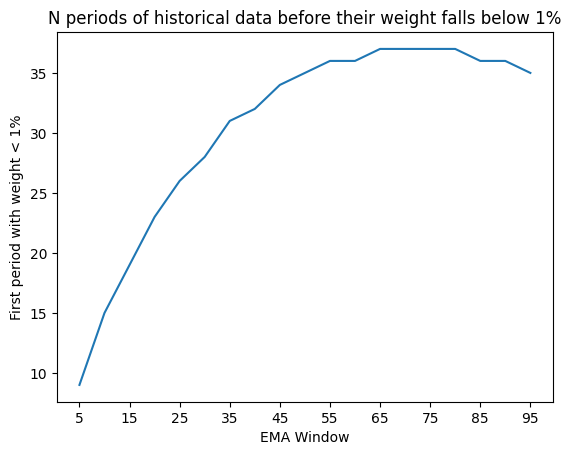

In [10]:
# Calculate how many days of padding I need to calculate an accurate EMA
precision = 0.01  # Weight smaller than 5%
paddings = []
for ema_window in np.arange(5, 100, 5):
    N_padding = int(
        np.ceil(
            np.log((ema_window + 1) * (precision / 2))
            / np.log((ema_window - 1) / (ema_window + 1))
        )
    )
    paddings.append(N_padding)

plt.plot(np.arange(5, 100, 5), paddings)
plt.xticks(np.arange(5, 100, 10))
plt.xlabel("EMA Window")
plt.ylabel("First period with weight < 1%")
plt.title("N periods of historical data before their weight falls below 1%")
plt.show()

In [11]:
### Functions to calculate the indicators ###


def calculate_MACD(
    time_data: pd.Series, short_window: int = 12, long_window: int = 26
) -> pd.Series:
    """Calculate the Moving Average Convergence Divergence (MACD) for a given time series.
    INPUTs:
    - data: pd.Series, the time series data
    - short_window, long_window: int, the short and long window periods for MACD line (EMA_short - EMA_long).
    OUTPUTs:
    - macd: pd.Series, as per definition
    """
    short_EMA = time_data.ewm(span=short_window, adjust=False).mean()
    long_EMA = time_data.ewm(span=long_window, adjust=False).mean()
    return short_EMA - long_EMA


def calculate_RSI(time_data: pd.Series, window: int = 14) -> pd.Series:
    """Calculate the Relative Strength Index (RSI) for a given time series.
    The Relative Strenght (RS) is a EMA of the gains and losses with smoothing factor based on 'window'.
    INPUTs:
    - data: pd.Series, the time series data
    - window: int, the window period for RSI
    OUTPUTs:
    - rsi: pd.Series, as per definition
    """
    delta = time_data.diff()
    gain = delta.where(delta > 0, other=0)
    loss = -delta.where(delta < 0, other=0)
    avg_gain = gain.ewm(com=window).mean()
    avg_loss = loss.ewm(com=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


### Functions to handle the database interactions ###


def log_execution(func):
    def wrapper(*args, **kwargs):
        if func.__name__ == "update_metal_indicators":
            logging.info(
                f"Updating metal indicators for {args[1]} from {args[2]} to {args[3]}."
            )
        elif func.__name__ == "add_column_MACD":
            logging.info("Adding column MACD to the database.")
        elif func.__name__ == "add_column_RSI":
            logging.info("Adding column RSI to the database.")
        else:
            logging.info(
                f"Running function {func.__name__} with arguments: {args} and keyword arguments: {kwargs}."
            )
        start_execution = time.time()
        result = func(*args, **kwargs)
        end_execution = time.time()
        logging.info(
            f"Finished execution of {func.__name__} in {end_execution - start_execution:.2f} seconds.\n"
        )
        return result

    return wrapper


@log_execution
def update_metal_indicators(
    df: pd.DataFrame, metal: str, start_date: pd.Timestamp, end_date: pd.Timestamp
) -> None:
    """Update the MetalPrices table in the database with the calculated MACD and RSI indicators.
    INPUTs:
    - df: pd.DataFrame, the dataframe with the calculated indicators
    - metal: str, the metal to update (e.g., 'COPPER')
    - start_date, end_date: pd.Timestamp, the date range to update (dd/mm/yyyy)
    """
    try:
        # Connect to the database
        conn = sqlite3.connect(f"{os.pardir}/market_data.db")
        cur = conn.cursor()

        # Select only dates of iterest
        df_filtered = df[(df["Dates"] >= start_date) & (df["Dates"] <= end_date)]

        # Loop through rows and update MACD and RSI for the specified metal
        for _, row in df_filtered.iterrows():
            # Convert the date to ISO format (YYYY-MM-DD)
            date_str = row["Dates"].strftime("%Y-%m-%d")

            cur.execute(
                """
                UPDATE MetalPrices
                SET MACD = ?, RSI = ?
                WHERE Date = ? AND Metal = ?;
            """,
                (row[f"MACD_{metal}"], row[f"RSI_{metal}"], date_str, metal),
            )

        conn.commit()
        cur.close()
    except sqlite3.Error as e:
        logging.error(f"Error when updating the database: {e}")
    finally:
        if conn:
            conn.close()


@log_execution
def add_column_MACD() -> None:
    """Add the MACD column to the MetalPrices table in the database. Do nothing if the column already exists."""
    try:
        # Open a connection to the database
        conn = sqlite3.connect(f"{os.pardir}/market_data.db")
        cur = conn.cursor()
        try:
            cur.execute("""
                ALTER TABLE MetalPrices
                ADD COLUMN MACD REAL DEFAULT NULL;
            """)
        except sqlite3.OperationalError as e:
            if "duplicate column name" in str(e):
                logging.warning("Column MACD already exists.")
            else:
                raise
        conn.commit()
        cur.close()
    except sqlite3.Error as e:
        logging.error(f"Error when adding column MACD: {e}")
    finally:
        if conn:
            conn.close()


@log_execution
def add_column_RSI() -> None:
    """Add the RSI column to the MetalPrices table in the database. Do nothing if the column already exists."""
    try:
        # Open a connection to the database
        conn = sqlite3.connect(f"{os.pardir}/market_data.db")
        cur = conn.cursor()
        try:
            cur.execute("""
                ALTER TABLE MetalPrices
                ADD COLUMN RSI REAL DEFAULT NULL;
            """)
        except sqlite3.OperationalError as e:
            if "duplicate column name" in str(e):
                logging.warning("Column RSI already exists.")
            else:
                raise
        conn.commit()
        cur.close()
    except sqlite3.Error as e:
        logging.error(f"Error when adding column RSI: {e}")
    finally:
        if conn:
            conn.close()


### Other functions ###


def load_data(
    data_path: str,
    metals: list[str],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    padding: int,
) -> pd.DataFrame:
    """Load the data from the CSV file and select the columns with the metals and time period (+ padding) of interest.
    INPUTs:
    - data_path: str, the path to the CSV file
    - metals: list of str, the metals to select (e.g., ['COPPER'])
    - start_date, end_date: pd.Timestamp, the date range to select (dd/mm/yyyy)
    - padding: int, the number of days to pad the start date for EMA calculations
    OUTPUTs:
    - df: pd.DataFrame, the dataframe with the selected columns and time period
    """

    raw_df = pd.read_csv(data_path)
    # Get columns names with selected metals
    columns_metals = raw_df.iloc[2, 1:-1].values
    columns_metals = [col.split(" ")[1] for col in columns_metals]
    # Get the mask of the columns to select, the first column is the date
    mask_columns = np.concatenate(([True], np.isin(columns_metals, metals), [False]))
    # Select only columns in the mask, also the first 6 rows are headers
    df = raw_df.iloc[6:, mask_columns].copy()
    df.columns = np.concatenate((["Dates"], metals))
    # Ensure the data types are correct. the format dd/mm/yyyy works better for pandas, but needs to be converted to yyyy-mm-dd in the database
    df["Dates"] = pd.to_datetime(df["Dates"], format="%d/%m/%Y", errors="coerce")
    for metal in metals:
        df[metal] = pd.to_numeric(df[metal], errors="coerce")
    # Select dates in the provided range and a padding at the beginning
    cutoff_date = start_date - timedelta(days=padding)
    df = df[(df["Dates"] > cutoff_date) & (df["Dates"] <= end_date)]
    # Check the data doesnt have any missing values, otherwise it needs addressing
    if not (df.isna().sum() == 0).all():
        raise ValueError(
            "There are NaN values in the data. Please check the data and try again."
        )
    return df


### Parameters ###

data_path = f"{os.pardir}/data/MarketData.csv"
# Metals to select
metals = ["COPPER", "ZINC"]
# Use a padding to calculate the EMA and RSI without a starting bias
padding = 50
# Dates to select
start_date = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
end_date = pd.to_datetime("31/12/2021", format="%d/%m/%Y")

# Load the data
df = load_data(data_path, metals, start_date, end_date, padding)

# Calculate the MACD and RSI for each metal
for metal in metals:
    df[f"MACD_{metal}"] = calculate_MACD(df[metal])
    df[f"RSI_{metal}"] = calculate_RSI(df[metal])

# Add the columns to the database and update the values
add_column_MACD()
add_column_RSI()
for metal in metals:
    update_metal_indicators(df, metal, start_date, end_date)

INFO:root:Adding column MACD to the database.
INFO:root:Finished execution of add_column_MACD in 0.00 seconds.

INFO:root:Adding column RSI to the database.
INFO:root:Finished execution of add_column_RSI in 0.00 seconds.

INFO:root:Updating metal indicators for COPPER from 2020-01-01 00:00:00 to 2021-12-31 00:00:00.
INFO:root:Finished execution of update_metal_indicators in 0.03 seconds.

INFO:root:Updating metal indicators for ZINC from 2020-01-01 00:00:00 to 2021-12-31 00:00:00.
INFO:root:Finished execution of update_metal_indicators in 0.02 seconds.

